In [27]:
import os
import glob
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from skimage.morphology import remove_small_objects, binary_erosion, disk 
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes, center_of_mass, binary_erosion
from skimage.filters import threshold_otsu, median 
from skimage.exposure import rescale_intensity 

# --- Variáveis Globais ---

# Caminho para o diretório de dados, relativo ao notebook em 'src/'
DATA_DIR = '../database/axl/'

# Número de imagens aleatórias para o batch
N_IMAGES_BATCH = 15

# Número de clusters (LCR, Matéria Cinzenta, Matéria Branca + 1 extra)
N_CLUSTERS = 4 

# Limite mínimo de área (em pixels) para componentes
MIN_AREA_VENTRICLE = 500
MIN_AREA_WM = 500 # Matéria Branca (White Matter)
MIN_AREA_GM = 500 # Matéria Cinzenta (Gray Matter)

# Lista para armazenar os caminhos dos arquivos selecionados para o batch
SELECTED_FILES = []

# Lista para armazenar os slices 2D originais para usar na Célula 3
ORIGINAL_SLICES = []

# Seed para reprodutibilidade
random.seed(64)

print("Bibliotecas importadas e variáveis globais definidas.")

Bibliotecas importadas e variáveis globais definidas.


Carregando 15 imagens aleatórias de ../database/axl/...
15 slices carregados na memória.


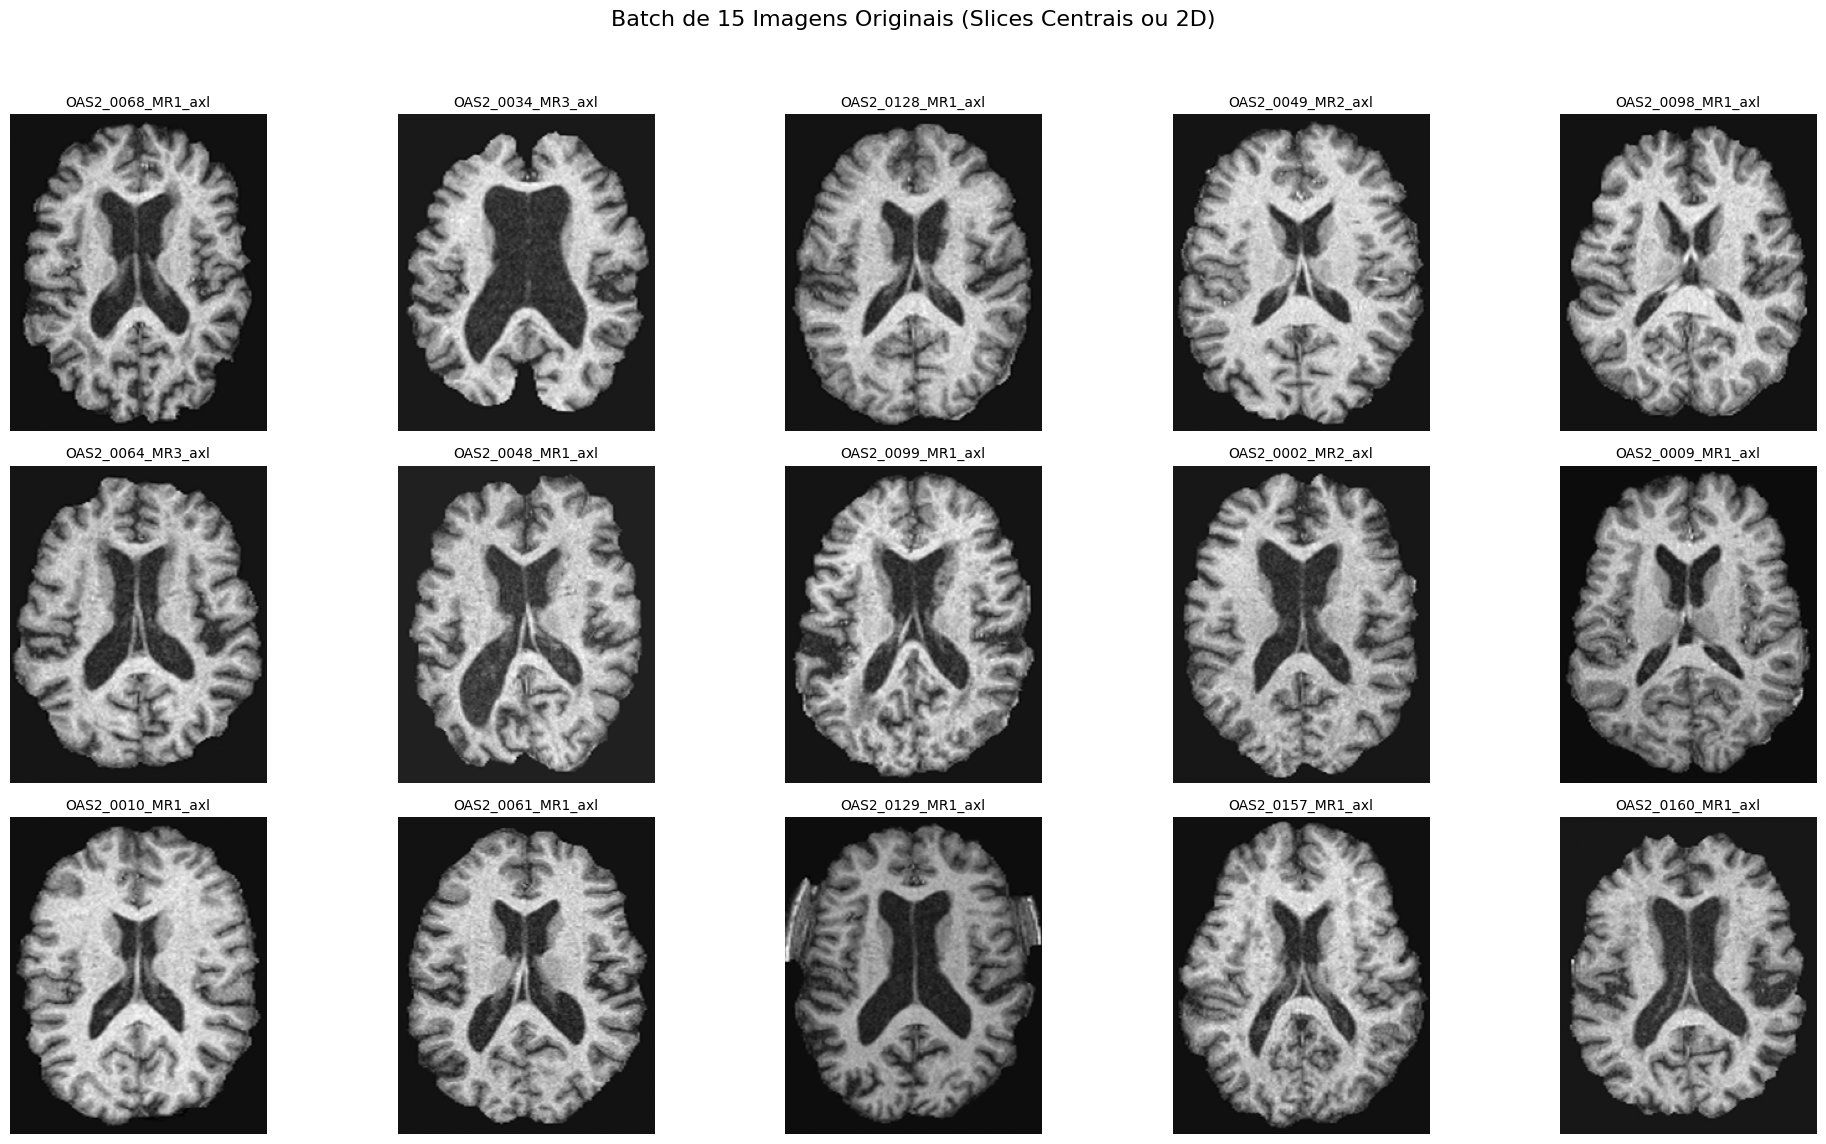

In [28]:
print(f"Carregando {N_IMAGES_BATCH} imagens aleatórias de {DATA_DIR}...")

# Limpa listas para re-execução
SELECTED_FILES = []
ORIGINAL_SLICES = []

# Busca todos os arquivos NIfTI no diretório
all_files = glob.glob(os.path.join(DATA_DIR, "*.nii.gz"))

if not all_files:
    print(f"Nenhum arquivo .nii.gz encontrado em {DATA_DIR}")
else:
    # Seleciona um batch aleatório de arquivos
    N_IMAGES_BATCH = min(N_IMAGES_BATCH, len(all_files))
    SELECTED_FILES_PATHS = random.sample(all_files, N_IMAGES_BATCH)
    
    # Carrega os slices
    for file_path in SELECTED_FILES_PATHS:
        nii_img = nib.load(file_path)
        data = nii_img.get_fdata()
        
        # Verifica a dimensionalidade dos dados
        if data.ndim == 3:
            # É um volume 3D, pega o slice central
            slice_z = data.shape[2] // 2
            slice_data = data[:, :, slice_z]
            ORIGINAL_SLICES.append(slice_data)
            SELECTED_FILES.append(file_path)
        
        elif data.ndim == 2:
            # Já é um slice 2D, apenas adiciona
            slice_data = data
            ORIGINAL_SLICES.append(slice_data)
            SELECTED_FILES.append(file_path)
            
        else:
            # Dados inesperados (1D, 4D, etc.)
            print(f"AVISO: Arquivo {os.path.basename(file_path)} ignorado. Dimensionalidade inesperada: {data.ndim}D")

    print(f"{len(ORIGINAL_SLICES)} slices carregados na memória.")

    plt.figure(figsize=(20, 12))
    for i, image_slice in enumerate(ORIGINAL_SLICES):
        plt.subplot(3, 5, i + 1)
        plt.imshow(np.rot90(image_slice), cmap='gray')
        filename = os.path.basename(SELECTED_FILES[i]).split('.')[0]
        plt.title(filename, fontsize=10)
        plt.axis('off')
    plt.suptitle(f"Batch de {len(SELECTED_FILES)} Imagens Originais (Slices Centrais ou 2D)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [29]:
def segmentar_estruturas(image_slice, n_clusters, min_area_vent, min_area_wm, min_area_gm):
    """
    Segmenta LCR, Matéria Branca e Cinzenta usando K-Means.
    """
    
    shape = image_slice.shape
    
    # 3. K-Means Segmentation
    # Prepara os dados para o KMeans: USA TODOS OS PIXELS DA IMAGEM
    pixels_imagem = image_slice.reshape(-1, 1)
    
    # Evita erro se a imagem estiver vazia
    if pixels_imagem.shape[0] == 0:
        return {
            'ventriculos': np.zeros(shape, dtype=bool),
            'materia_branca': np.zeros(shape, dtype=bool),
            'materia_cinzenta': np.zeros(shape, dtype=bool)
        }

    # Garante que n_clusters não seja maior que os valores únicos
    n_unique_values = len(np.unique(pixels_imagem))
    if n_clusters > n_unique_values:
        print(f"Aviso: N_CLUSTERS ({n_clusters}) é maior que os valores únicos ({n_unique_values}). Ajustando n_clusters.")
        n_clusters = n_unique_values
        
    # Se n_clusters for muito baixo após o ajuste, não podemos segmentar 3 tecidos
    if n_clusters < 4:
        print(f"Aviso: Imagem com poucos valores únicos ({n_unique_values}). Pulando segmentação.")
        return {
            'ventriculos': np.zeros(shape, dtype=bool),
            'materia_branca': np.zeros(shape, dtype=bool),
            'materia_cinzenta': np.zeros(shape, dtype=bool)
        }
        
    kmeans = KMeans(n_clusters=n_clusters, random_state=64, n_init=10).fit(pixels_imagem)
    centers = kmeans.cluster_centers_.flatten()
    labels_flat = kmeans.labels_

    # 4. Identificação de Estruturas
    sorted_indices = np.argsort(centers)

    # O cluster com a segunda menor intensidade são os ventrículos/LCR
    indice_ventriculos = sorted_indices[1]
    # O cluster com maior intensidade é a matéria branca
    indice_materia_branca = sorted_indices[-1] # Equivale a sorted_indices[3]
    # O segundo cluster de maior intensidade é a matéria cinzenta
    indice_materia_cinzenta = sorted_indices[-2] # Equivale a sorted_indices[2]

    # 5. Criar Máscaras
    # Mapeia as labels de volta para a imagem 2D (shape original)
    all_labels = labels_flat.reshape(shape)

    mask_ventriculos = (all_labels == indice_ventriculos)
    mask_materia_branca = (all_labels == indice_materia_branca)
    mask_materia_cinzenta = (all_labels == indice_materia_cinzenta)

    # 6. Pós-processamento
    mask_ventriculos = remove_small_objects(mask_ventriculos, min_size=min_area_vent)
    mask_ventriculos = binary_fill_holes(mask_ventriculos)
    
    mask_materia_branca = remove_small_objects(mask_materia_branca, min_size=min_area_wm)
    mask_materia_branca = binary_fill_holes(mask_materia_branca)

    mask_materia_cinzenta = remove_small_objects(mask_materia_cinzenta, min_size=min_area_gm)
    mask_materia_cinzenta = binary_fill_holes(mask_materia_cinzenta)

    return {
        'ventriculos': mask_ventriculos,
        'materia_branca': mask_materia_branca,
        'materia_cinzenta': mask_materia_cinzenta
    }

print("Célula 3 executada: Função 'segmentar_estruturas' definida.")

Célula 3 executada: Função 'segmentar_estruturas' definida.


Executando pipeline e plotando resultados...


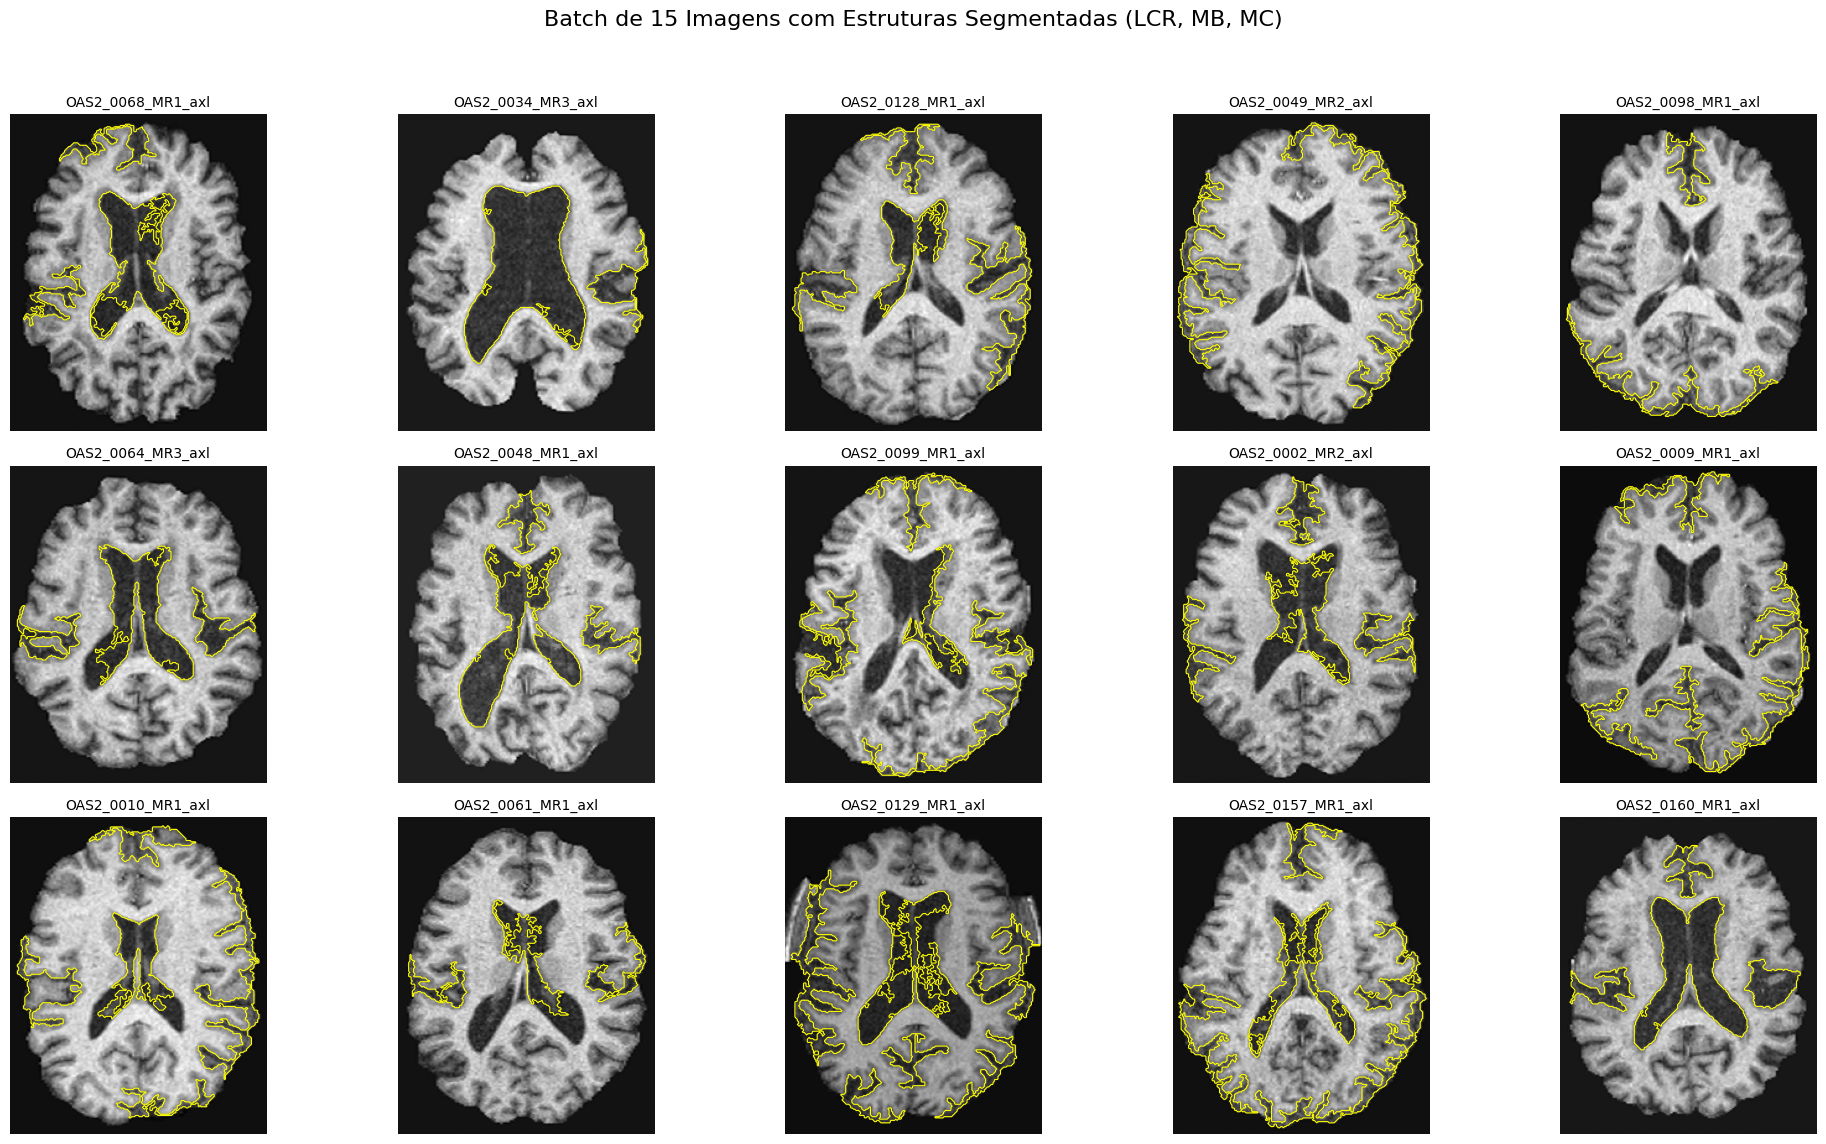

In [30]:
print("Executando pipeline e plotando resultados...")

if not ORIGINAL_SLICES:
    print("Nenhuma imagem carregada. Execute a Célula 2 primeiro.\n")
else:
    plt.figure(figsize=(20, 12))
    
    for i, image_slice in enumerate(ORIGINAL_SLICES):
        # 1. Gerar as máscaras de segmentação
        masks = segmentar_estruturas(image_slice, 
                                       N_CLUSTERS, 
                                       MIN_AREA_VENTRICLE, 
                                       MIN_AREA_WM, 
                                       MIN_AREA_GM)
        
        # 2. Plotar a imagem original
        plt.subplot(3, 5, i + 1)
        plt.imshow(np.rot90(ORIGINAL_SLICES[i]), cmap='gray')
        
        # 3. Sobrepor os contornos
        if np.any(masks['ventriculos']):
            # LCR/Ventrículos em Ciano
            plt.contour(np.rot90(masks['ventriculos']), colors='yellow', linewidths=0.8)
         
        # 4. Título e eixos
        filename = os.path.basename(SELECTED_FILES[i]).split('.')[0]
        plt.title(filename, fontsize=10)
        plt.axis('off')

    plt.suptitle(f"Batch de {len(SELECTED_FILES)} Imagens com Estruturas Segmentadas (LCR, MB, MC)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()